### 한글 손 글씨 글자 분류기

<br>

[다양한 형태의 한글 문자 OCR](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=91)
<br>[한글 손 글씨 글자 분류기](https://aifactory.space/task/2656/baseline)

<br>

In [ ]:
!pip install pydot
!pip install datasets
sudo apt install graphviz
!pip install -U tensorflow-addons

### CNN

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import PIL
from tqdm import tqdm

import os
import json

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [2]:
train_x_path = 'data/train_x.npy'
train_y_path = 'data/train_y.npy'
test_x_path = 'data/test_x.npy'

train_x = np.load(train_x_path)
train_y = np.load(train_y_path)
test_x = np.load(test_x_path)

for idx, (x, y) in enumerate(zip(train_x, train_y)):  
    train_img = PIL.Image.fromarray(x)
    train_img.save('data/image/' + y + "/train_" + str(idx) + '.png','PNG')

for idx, test in enumerate(test_x):  
    test_img = PIL.Image.fromarray(test)
    test_img.save('data/test/' + str(idx) + '.png','PNG')

In [2]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
 'data/image/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 1888 files belonging to 14 classes.
Using 1511 files for training.


2023-11-12 14:47:47.762294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9538 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-11-12 14:47:47.762881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21245 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


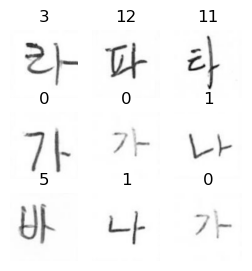

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
"""
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(3, 3))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

"""

In [5]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=14)
# keras.utils.plot_model(model, show_shapes=True)

In [6]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    # loss="binary_crossentropy",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    # validation_data=val_ds,
)

Epoch 1/5


2023-11-12 14:48:00.445459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-12 14:48:02.323881: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbf77f35610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-12 14:48:02.323902: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-12 14:48:02.323907: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-12 14:48:02.327638: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-12 14:48:02.458943: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 11s 58ms/step - loss: 1.6385 - accuracy: 0.4739
Epoch 2/5
48/48 [==============================] - 2s 42ms/step - loss: 0.5328 - accuracy: 0.8484
Epoch 3/5
48/48 [==============================] - 2s 42ms/step - loss: 0.2450 - accuracy: 0.9385
Epoch 4/5
48/48 [==============================] - 2s 42ms/step - loss: 0.1204 - accuracy: 0.9729
Epoch 5/5
48/48 [==============================] - 2s 42ms/step - loss: 0.0551 - accuracy: 0.9894


In [7]:
def sorted_list(path_list):
    
    path_list = sorted(path_list, reverse=False)
    path_list = sorted(path_list, key=len)
    
    return path_list

In [ ]:
path_list = sorted_list(glob("data/image/**/*.png"))

predictions = []
load_model = tf.keras.models.load_model('save_at_2.keras')
for idx, path in enumerate(path_list):
    img = keras.utils.load_img(
        path, target_size=image_size
    )
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = load_model.predict(img_array)
    prediction = np.argmax(prediction[0])
    predictions.append(prediction)
    # plt.imshow(img)
    print()
    print(idx, prediction)

# np.save('y_pred.npy', predictions)   

### CNN 2

In [29]:
import numpy as np
import sys
import tensorflow as tf
from tensorflow import keras

x_train_path = 'data/train_x.npy'
y_train_path = 'data/train_y.npy'
x_test_path = 'data/test_x.npy'

x_train = np.load(x_train_path)
y_train = np.load(y_train_path)

# 데이터 정규화: 이미지 픽셀 값을 [0, 1] 범위로 스케일링
x_train = x_train.astype('float32') / 255.0

# 라벨링을 숫자로 변환
unique_labels = sorted(list(set(y_train)))
label_to_index = {label: i for i, label in enumerate(unique_labels)}
y_train = np.array([label_to_index[label] for label in y_train])

# CNN 모델 정의
model = keras.Sequential([
    keras.layers.Reshape((128, 128, 1), input_shape=(128, 128)),  # 차원 추가
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(unique_labels), activation='softmax')
])

# 모델 컴파일 with custom learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10, batch_size=32)

# 학습 결과 저장
np.save('train_history.npy', history.history)

# 모델 저장
model.save('model.h5')


Epoch 1/10
48/48 [==============================] - 2s 10ms/step - loss: 2.6512 - accuracy: 0.0861
Epoch 2/10
48/48 [==============================] - 0s 7ms/step - loss: 2.3504 - accuracy: 0.2563
Epoch 3/10
48/48 [==============================] - 0s 8ms/step - loss: 1.6203 - accuracy: 0.5252
Epoch 4/10
48/48 [==============================] - 0s 8ms/step - loss: 0.9379 - accuracy: 0.7113
Epoch 5/10
48/48 [==============================] - 0s 8ms/step - loss: 0.5158 - accuracy: 0.8642
Epoch 6/10
48/48 [==============================] - 0s 8ms/step - loss: 0.2653 - accuracy: 0.9311
Epoch 7/10
48/48 [==============================] - 0s 8ms/step - loss: 0.1292 - accuracy: 0.9821
Epoch 8/10
48/48 [==============================] - 0s 8ms/step - loss: 0.0612 - accuracy: 0.9914
Epoch 9/10
48/48 [==============================] - 0s 8ms/step - loss: 0.0249 - accuracy: 1.0000
Epoch 10/10
48/48 [==============================] - 0s 8ms/step - loss: 0.0127 - accuracy: 1.0000


In [31]:
import numpy as np
import sys
from tensorflow.keras.models import load_model

In [32]:
model_path = 'model.h5'
x_test_path = 'data/test_x.npy'
y_pred_save_path = 'data/pred_y.npy'

model = load_model(model_path)
x_test = np.load(x_test_path)

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

np.save(y_pred_save_path, y_pred_labels)

12/12 [==============================] - 0s 6ms/step


### Reference

[[Python] Tensorflow로 나만의 데이터셋 만들기](https://stickode.tistory.com/670)
<br>[이미지 로드 및 전처리하기](https://www.tensorflow.org/tutorials/load_data/images?hl=ko)
<br>[Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

[[Python] Tensorflow로 나만의 데이터셋 만들기](https://stickode.tistory.com/670)
<br>[이미지 로드 및 전처리하기](https://www.tensorflow.org/tutorials/load_data/images?hl=ko)
<br>[Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)